In [1]:
!pip install opensmile praat-parselmouth librosa soundfile pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 14.9 MB/s eta 0:00:00


In [2]:
!pip install webrtcvad pydub scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp312-cp312-linux_x86_64.whl size=73520 sha256=63f082ffd5d14739204250cac6350905c6e9d2cc1e9cf37a926fb6b80a545df7
  Stored in directory: /root/.cache/pip/wheels/1e/d3/95/680fa3b16848f1a58d2edaed34c496224c89a9bc63e17b3614
Successfully built webrtcvad


In [3]:

!pip install --upgrade sympy
!pip install moviepy==1.0.3
!pip install audiomentations soundfile librosa tqdm
!pip install -U audiomentations


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: soxr
    Found existing installation: soxr 1.0.0
    Uninstalling soxr-1.0.0:
      Successfully uninstalled soxr-1.0.0


# Importing Libraries

In [20]:
import os
import numpy as np
import pandas as pd
import librosa
import opensmile
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
import torch.optim as optim

# Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Video Dataset




In [ ]:
# @title
def load_data_videos():
  path_videos = '/content/mydrive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/Video_Files'
  data = []  # To store (video_path, label) tuples

  classes = {
      "normal_people": 0,
      "down_syndrome_people": 1
  }

  for class_name, label in classes.items():
    folder_path = os.path.join(path_videos, class_name)

    if not os.path.exists(folder_path):
      print(f"Folder not found: {folder_path}")
      continue

    for file in os.listdir(folder_path):
      if file.endswith(".mp4"):
        print('FILE::::', file)
        video_path = os.path.join(folder_path, file)
        data.append((video_path, label))
        print(f"Loaded: {video_path} -> Label: {label}")

  print(f"Total videos loaded: {len(data)}")
  return data

data_videos = load_data_videos()
print(f"videos: {len(data_videos)}")

# Extract Audio from Video



In [ ]:
# @title
from moviepy.editor import VideoFileClip

def extract_audios_from_videos(data, output_base_folder):
    for video_path, label in data:
        # Choose subfolder based on label
        subfolder = "normal_people" if label == 0 else "down_syndrome_people"
        output_folder = os.path.join(output_base_folder, subfolder)

        # Create subfolder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)

        # Get filename (without .mp4)
        filename = os.path.splitext(os.path.basename(video_path))[0]
        audio_filename = f"{filename}.wav"
        audio_path = os.path.join(output_folder, audio_filename)

        # ✅ Skip if audio already exists
        if os.path.exists(audio_path):
            print(f"Skipping {video_path} (already extracted).")
            continue

        print(f"Processing {video_path} -> {audio_path}")

        try:
            video = VideoFileClip(video_path)
            audio = video.audio
            if audio is not None:
                audio.write_audiofile(audio_path, logger=None)
                video.close()
                print(f"Saved audio: {audio_path}")
            else:
                print(f"No audio stream found in: {video_path}")
        except Exception as e:
            print(f"Error processing {video_path}: {e}")

output_audio_folder = '/content/mydrive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/Audio_Files'
data_audio = extract_audios_from_videos(data_videos, output_audio_folder)

# Data Augmentation

In [ ]:
# @title
# =============================================================
# DATA AUGMENTATION + SPEECH DETECTION + MUSIC REMOVAL PIPELINE
# =============================================================

import os
import random
import librosa
import numpy as np
import soundfile as sf
import webrtcvad
from pathlib import Path
from pydub import AudioSegment
import warnings
warnings.filterwarnings("ignore")

# ===================== CONFIG =====================
SOURCE_DIR = "/content/drive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/Audio_Files"
OUTPUT_DIR = "/content/drive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/Augmented_Audio_Files"
SKIPPED_DIR = "/content/drive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/Skipped"

FIXED_SEGMENT = 5.0
MIN_ACCEPTABLE = 3.0

NOISE_PROBABILITY = 0.5
NOISE_STD = 0.005

VAD_AGGRESSIVENESS = 2
MIN_SPEECH_RATIO = 0.06

RMS_FILE_FACTOR = 0.25
ZCR_MAX = 0.30
USE_LIBROSA_FALLBACK = True

# Counters
count_normal = 0
count_down = 0
skipped_count = 0
file_id_normal = 0
file_id_down = 0

vad = webrtcvad.Vad(VAD_AGGRESSIVENESS)


# ===================== UTILITIES =====================

def safe_rms(arr):
    if len(arr) == 0:
        return 0.0
    arr = np.nan_to_num(arr)
    return float(np.sqrt(np.mean(arr ** 2)))


def zcr(arr):
    if len(arr) == 0:
        return 0.0
    return float(((arr[:-1] * arr[1:]) < 0).sum() / len(arr))


def add_noise(audio, noise_std=NOISE_STD):
    noise = np.random.normal(0, noise_std, audio.shape)
    return np.clip(audio + noise, -1.0, 1.0)


def split_audio_fixed(audio, sr):
    total_len = len(audio)
    segment_len = int(FIXED_SEGMENT * sr)
    min_len = int(MIN_ACCEPTABLE * sr)

    segments = []
    for start in range(0, total_len, segment_len):
        seg = audio[start:start + segment_len]

        if len(seg) >= min_len:
            seg = np.pad(seg, (0, segment_len - len(seg)), 'constant')
            segments.append(seg)

    return segments


# ===================== NEW: MUSIC DETECTORS =====================

def is_music_spectrum(wav, sr):
    """Detect music based on spectral flatness & centroid."""
    if len(wav) < sr * 0.5:
        return False

    S = np.abs(librosa.stft(wav, n_fft=1024, hop_length=512))

    flatness = librosa.feature.spectral_flatness(S=S).mean()
    centroid = librosa.feature.spectral_centroid(S=S).mean() / (sr/2)
    rolloff = librosa.feature.spectral_rolloff(S=S).mean() / (sr/2)

    if flatness > 0.35 and centroid > 0.45:
        return True
    if centroid > 0.60 and rolloff > 0.80:
        return True

    return False


def is_music_energy_pattern(wav):
    """Music has steady RMS with very low variance."""
    rms = librosa.feature.rms(y=wav)[0]
    if np.std(rms) < 0.015:   # speech fluctuates, music is stable
        return True
    return False


# ===================== ADVANCED SPEECH DETECTOR =====================

def is_real_speech_adaptive(wav, sr):
    if len(wav) == 0:
        return False, "empty"

    file_rms = safe_rms(wav)
    adaptive_rms_threshold = max(1e-6, file_rms * RMS_FILE_FACTOR)
    file_zcr = zcr(wav)

    # MUSIC FILTERS
    if is_music_spectrum(wav, sr):
        return False, "music_spectrum_detected"
    if is_music_energy_pattern(wav):
        return False, "music_energy_pattern"

    if file_rms < 1e-6:
        return False, f"global_rms_too_low ({file_rms:.5f})"

    audio16 = (wav * 32768).astype(np.int16)
    frame_len = int(sr * 0.03)

    speech_frames = 0
    total_frames = 0

    for start in range(0, len(audio16), frame_len):
        frame = audio16[start:start + frame_len]
        if len(frame) < frame_len:
            continue

        total_frames += 1
        try:
            is_s = vad.is_speech(frame.tobytes(), sr)
        except:
            is_s = False

        frame_rms = safe_rms(frame.astype(np.float32) / 32768.0)
        if is_s and frame_rms >= adaptive_rms_threshold:
            speech_frames += 1

    speech_ratio = speech_frames / total_frames if total_frames else 0.0

    if speech_ratio >= MIN_SPEECH_RATIO:
        return True, f"vad_ok ratio={speech_ratio:.3f}"

    # Fallback using librosa
    if USE_LIBROSA_FALLBACK:
        nonsilent = librosa.effects.split(wav, top_db=35)
        voiced = sum(e - s for s, e in nonsilent)
        voiced_ratio = voiced / len(wav)

        if voiced_ratio >= 0.02:
            return True, f"librosa_ok voiced_ratio={voiced_ratio:.3f}"
        else:
            return False, f"low_voiced_ratio={voiced_ratio:.3f}"

    return False, "vad_failed"


# ===================== PROCESS AUDIO FILE =====================

def process_audio_file(file_path):
    global count_normal, count_down, file_id_normal, file_id_down, skipped_count

    try:
        orig = file_path

        # MP3 → WAV convert
        if orig.lower().endswith(".mp3"):
            sound = AudioSegment.from_mp3(orig)
            temp_wav = orig[:-4] + ".wav"
            sound.export(temp_wav, format="wav")
            file_path = temp_wav

        wav, sr = librosa.load(file_path, sr=16000)

        is_speech, reason = is_real_speech_adaptive(wav, sr)

        if not is_speech:
            skipped_count += 1
            print(f"⚠️ Skipped: {orig} — reason: {reason}")
            Path(SKIPPED_DIR).mkdir(parents=True, exist_ok=True)
            sf.write(f"{SKIPPED_DIR}/{os.path.basename(orig)}", wav, sr)
            return

        # SPEECH ACCEPTED → Split
        segments = split_audio_fixed(wav, sr)
        rel = Path(orig).relative_to(SOURCE_DIR)

        if "down" in str(rel).lower():
            prefix, file_id_down = "DS", file_id_down + 1
            id_str = f"{file_id_down:03d}"
        elif "normal" in str(rel).lower():
            prefix, file_id_normal = "N", file_id_normal + 1
            id_str = f"{file_id_normal:03d}"
        else:
            prefix, id_str = "UNK", "000"

        save_dir = Path(OUTPUT_DIR) / rel.parent
        save_dir.mkdir(parents=True, exist_ok=True)

        saved = 0
        for i, seg in enumerate(segments):
            aug = seg.copy()
            if random.random() < NOISE_PROBABILITY:
                aug = add_noise(aug)

            name = f"{prefix}{id_str}_seg{i+1}.wav"
            sf.write(save_dir / name, aug, sr)
            saved += 1

        if prefix == "N":
            count_normal += saved
        elif prefix == "DS":
            count_down += saved

        print(f"✅ {orig} → {saved} segments (reason: {reason})")

    except Exception as e:
        print(f"❌ Error: {file_path} — {e}")


# ===================== MAIN LOOP =====================

all_files = []
for root, _, files in os.walk(SOURCE_DIR):
    for f in files:
        if f.lower().endswith((".wav", ".mp3")):
            all_files.append(os.path.join(root, f))

print(f"🎧 Found {len(all_files)} audio files.\n")

for f in all_files:
    process_audio_file(f)

# ===================== SUMMARY =====================

print("\n🎉 PROCESSING DONE!")
print("📊 FINAL SUMMARY:")
print(f"🧠 Down Syndrome Segments: {count_down}")
print(f"🎙️ Normal Speech Segments: {count_normal}")
print(f"❌ Skipped Non-Speech Clips: {skipped_count}")
print(f"📁 Skipped → {SKIPPED_DIR}")


# Extract Audio Features

✅ MFCC (global) shape: (10201, 26)
✅ GeMAPS shape: (10201, 88)
✅ Labels shape: (10201,)
✅ Temporal MFCCs extracted: 10201 sequences


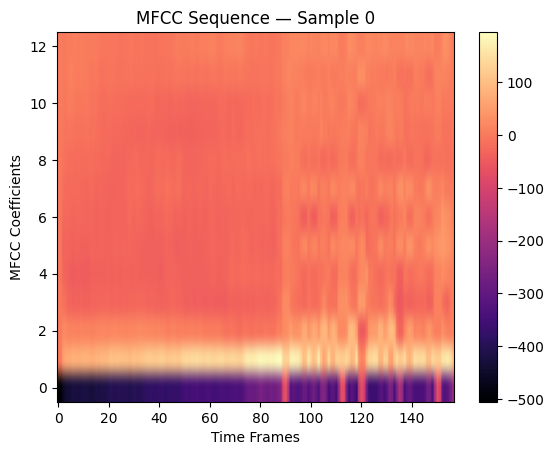

💾 Saved Pickle Files:
 - Global MFCCs → /content/drive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/saved_models/mfcc_global.pkl
 - Temporal MFCCs → /content/drive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/saved_models/mfcc_temporal.pkl
 - eGeMAPS → /content/drive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/saved_models/gemaps.pkl
📊 CSV with features saved for EDA → /content/drive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/saved_models/audio_features_debug.csv


In [12]:
import os
import librosa
import numpy as np
import pickle
import opensmile
import pandas as pd
from sklearn.preprocessing import StandardScaler

# --- MFCC extraction (per-frame + global) ---
def extract_mfcc(audio_path, n_mfcc=13):
    y, sr = librosa.load(audio_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # shape: [13, T]

    mfcc_mean = np.mean(mfcc, axis=1)  # shape: [13]
    mfcc_std = np.std(mfcc, axis=1)    # shape: [13]

    mfcc_global = np.concatenate([mfcc_mean, mfcc_std])  # shape: [26]
    return mfcc, mfcc_global


# --- eGeMAPs extraction (global) ---
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals
)

def extract_egemaps(audio_path):
    features_df = smile.process_file(audio_path)
    return features_df.iloc[0].values.flatten()  # ~88 features


# --- Dataset Paths ---
paths_and_labels = [
    ('/content/drive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/Augmented_Audio_Files/normal_people', 0),
    ('/content/drive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/Augmented_Audio_Files/down_syndrome_people', 1)
]

# --- Initialize containers ---
mfcc_temporal = []
mfcc_global = []
egemaps_features = []
labels = []

# --- Loop over all audio files ---
for folder, label in paths_and_labels:
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            audio_path = os.path.join(folder, file)
            try:
                mfcc_seq, mfcc_glob = extract_mfcc(audio_path)
                egemaps_vec = extract_egemaps(audio_path)

                mfcc_temporal.append(mfcc_seq)
                mfcc_global.append(mfcc_glob)
                egemaps_features.append(egemaps_vec)
                labels.append(label)

            except Exception as e:
                print(f"❌ Error processing {file}: {e}")

# --- Convert to arrays ---
mfcc_global = np.array(mfcc_global)
egemaps_features = np.array(egemaps_features)
labels = np.array(labels)

# --- Normalize only global features ---
scaler_mfcc = StandardScaler()
mfcc_global = scaler_mfcc.fit_transform(mfcc_global)

scaler_egemaps = StandardScaler()
egemaps_features = scaler_egemaps.fit_transform(egemaps_features)

print("✅ MFCC (global) shape:", mfcc_global.shape)
print("✅ eGeMAPS shape:", egemaps_features.shape)
print("✅ Labels shape:", labels.shape)
print(f"✅ Temporal MFCCs extracted: {len(mfcc_temporal)} sequences")
plt.imshow(mfcc_temporal[0], aspect='auto', origin='lower', cmap='magma')
plt.title("MFCC Sequence — Sample 0")
plt.xlabel("Time Frames")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()

# --- Save outputs ---
base_path = "/content/drive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/saved_models"

with open(f"{base_path}/mfcc_global.pkl", "wb") as f:
    pickle.dump((mfcc_global, labels), f)

with open(f"{base_path}/mfcc_temporal.pkl", "wb") as f:
    pickle.dump((mfcc_temporal, labels), f)

with open(f"{base_path}/egemaps.pkl", "wb") as f:
    pickle.dump((egemaps_features, labels), f)

with open(f"{base_path}/scaler_mfcc.pkl", "wb") as f:
    pickle.dump(scaler_mfcc, f)

with open(f"{base_path}/scaler_egemaps.pkl", "wb") as f:
    pickle.dump(scaler_egemaps, f)

print("💾 Saved Pickle Files:")
print(f" - Global MFCCs → {base_path}/mfcc_global.pkl")
print(f" - Temporal MFCCs → {base_path}/mfcc_temporal.pkl")
print(f" - eGeMAPS → {base_path}/gemaps.pkl")


# --- Save combined features CSV for EDA ---
try:
    combined_features = np.concatenate([mfcc_global, egemaps_features], axis=1)

    feature_names = (
        [f"mfcc_{i}" for i in range(mfcc_global.shape[1])] +
        [f"egemaps_{i}" for i in range(egemaps_features.shape[1])]
    )

    df = pd.DataFrame(combined_features, columns=feature_names)
    df["label"] = labels

    csv_path = f"{base_path}/audio_features_debug.csv"
    df.to_csv(csv_path, index=False)

    print(f"📊 CSV with features saved for EDA → {csv_path}")

except Exception as e:
    print(f"❌ Error while saving CSV: {e}")


In [ ]:
# Merged feature extraction with clinical features for severity (MFCC + eGeMAPS + Custom)
import os
import numpy as np
import pandas as pd
import librosa
import pickle
import parselmouth
from parselmouth.praat import call
from tqdm import tqdm
from opensmile import Smile, FeatureSet, FeatureLevel
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# ---------------------------
# USER PATHS (match yours)
# ---------------------------
INPUT_DIR = "/content/mydrive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/Augmented_Audio_Files"
OUTPUT_DIR = "/content/mydrive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/saved_models"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------------------
# Init eGeMAPS (opensmile)
# ---------------------------
smile = Smile(feature_set=FeatureSet.eGeMAPSv02, feature_level=FeatureLevel.Functionals)

# ---------------------------
# Utility
# ---------------------------
def save_pkl(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f)

def safe_float(x):
    try:
        return float(x)
    except:
        return 0.0

# ---------------------------
# MFCC global (26)
# ---------------------------
def extract_mfcc_global(y, sr, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    means = np.mean(mfcc, axis=1)
    stds = np.std(mfcc, axis=1)
    mfcc_global = np.concatenate([means, stds])
    return mfcc, mfcc_global  # shape (26,)

# ---------------------------
# Custom prosody & fluency (original) + additions
# ---------------------------
def extract_custom_features_from_wavefile(path, y=None, sr=None, sample_sr=16000):
    # We accept either raw y,sr or file path. Use parselmouth via file path for robust pitch/formants.
    if y is None or sr is None:
        y, sr = librosa.load(path, sr=sample_sr)
    else:
        # resample if needed for opensmile consistency (opensmile handled separately)
        if sr != sample_sr:
            y = librosa.resample(y, orig_sr=sr, target_sr=sample_sr)
            sr = sample_sr

    duration = librosa.get_duration(y=y, sr=sr)

    # --- speech rate using librosa tempo as proxy (may be noisy for very short clips) ---
    try:
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        tempo = float(tempo) if not isinstance(tempo, (list, np.ndarray)) else float(tempo[0])
        speech_rate = tempo / 60.0
    except:
        speech_rate = 0.0

    # --- voiced/unvoiced ratio using librosa non-silent frames (approx) ---
    try:
        nonsilent = librosa.effects.split(y, top_db=25)
        voiced_total = sum((e - s) for s, e in nonsilent) / float(sr) if len(nonsilent) > 0 else 0.0
        vu_ratio = voiced_total / duration if duration > 0 else 0.0
    except:
        vu_ratio = 0.0

    # --- pause detection (long pauses >0.2s) ---
    try:
        sil = librosa.effects.split(y, top_db=40)
        pause_durations = []
        prev_end = 0
        for seg_start, seg_end in sil:
            pause = (seg_start - prev_end) / sr
            if pause > 0.20:
                pause_durations.append(pause)
            prev_end = seg_end
        long_pause_count = int(len(pause_durations))
        long_pause_mean = float(np.mean(pause_durations)) if pause_durations else 0.0
    except:
        long_pause_count = 0
        long_pause_mean = 0.0

    # --- energy drop count ---
    try:
        rmse = librosa.feature.rms(y=y)[0]
        energy_drop_count = int(np.sum(rmse < np.percentile(rmse, 10)))
    except:
        energy_drop_count = 0

    # --- Use parselmouth for reliable pitch/formant/jitter/shimmer/HNR ---
    # Use file path for parselmouth Sound for best stability
    try:
        snd = parselmouth.Sound(path)  # robust
        # pitch
        pitch = call(snd, "To Pitch", 0.0, 75, 600)
        mean_f0 = safe_float(call(pitch, "Get mean", 0, 0, "Hertz"))
        min_f0 = safe_float(call(pitch, "Get minimum", 0, 0, "Hertz", "Parabolic"))
        max_f0 = safe_float(call(pitch, "Get maximum", 0, 0, "Hertz", "Parabolic"))
        if mean_f0 <= 0 or np.isnan(mean_f0):
            mean_f0 = 0.0
        # jitter / shimmer
        point_proc = call(snd, "To PointProcess (periodic, cc)", 75, 600)
        try:
            jitter_local = safe_float(call(point_proc, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3))
        except:
            jitter_local = 0.0
        try:
            shimmer_local = safe_float(call([snd, point_proc], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3))
        except:
            shimmer_local = 0.0
        # HNR
        try:
            harmonicity = call(snd, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
            hnr = safe_float(call(harmonicity, "Get mean", 0, 0))
        except:
            hnr = 0.0

        # --- Formants sampling for F1,F2,F3 series ---
        try:
            formants = call(snd, "To Formant (burg)", 0.005, 5, 5500, 0.025, 50)
            # sample times across duration (use up to 20 samples or denser for longer files)
            dur = snd.get_total_duration()
            n_samples = max(10, int(min(200, dur * 100)))  # cap samples
            times = np.linspace(0 + 0.01, max(0.01, dur - 0.01), n_samples)
            F1_vals, F2_vals, F3_vals = [], [], []
            for t in times:
                try:
                    f1 = call(formants, "Get value at time", 1, t, "Hertz")
                    f2 = call(formants, "Get value at time", 2, t, "Hertz")
                    f3 = call(formants, "Get value at time", 3, t, "Hertz")
                    if f1 is None or f2 is None:
                        continue
                    if f1 > 0:
                        F1_vals.append(f1)
                    if f2 > 0:
                        F2_vals.append(f2)
                    if f3 is not None and f3 > 0:
                        F3_vals.append(f3)
                except:
                    pass
            F1_vals = np.array(F1_vals) if len(F1_vals) > 0 else np.array([])
            F2_vals = np.array(F2_vals) if len(F2_vals) > 0 else np.array([])
            F3_vals = np.array(F3_vals) if len(F3_vals) > 0 else np.array([])
        except:
            F1_vals = np.array([])
            F2_vals = np.array([])
            F3_vals = np.array([])

        # Formant Centralization Ratio (FCR)
        if len(F1_vals) > 0 and len(F2_vals) > 0 and np.mean(F1_vals) > 0:
            FCR = float(np.mean(F2_vals) / np.mean(F1_vals))
        else:
            FCR = 0.0

        # Formant dispersion: mean differences between adjacent formants (F2-F1, F3-F2)
        fdiffs = []
        if len(F1_vals) > 0 and len(F2_vals) > 0:
            # align lengths by truncation for simple dispersion estimate
            L = min(len(F1_vals), len(F2_vals))
            fdiffs.append(np.mean(F2_vals[:L] - F1_vals[:L]))
        if len(F2_vals) > 0 and len(F3_vals) > 0:
            L = min(len(F2_vals), len(F3_vals))
            fdiffs.append(np.mean(F3_vals[:L] - F2_vals[:L]))
        formant_dispersion = float(np.mean(fdiffs)) if fdiffs else 0.0

        # Vowel Space Area (VSA) approx:
        # use extremes: F1_min, F1_max and F2_min, F2_max to create triangle area proxy
        vsa = 0.0
        try:
            if len(F1_vals) > 0 and len(F2_vals) > 0:
                F1_min, F1_max, F1_mean = np.min(F1_vals), np.max(F1_vals), np.mean(F1_vals)
                F2_min, F2_max, F2_mean = np.min(F2_vals), np.max(F2_vals), np.mean(F2_vals)
                # three points:
                p1 = (F1_min, F2_max)
                p2 = (F1_max, F2_min)
                p3 = (F1_mean, F2_mean)
                # polygon area (triangle)
                x1, y1 = p1; x2, y2 = p2; x3, y3 = p3
                vsa = 0.5 * abs(x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2))
                vsa = float(vsa)
        except:
            vsa = 0.0

    except Exception as e:
        # parselmouth failed; fallback to zeros
        mean_f0 = min_f0 = max_f0 = jitter_local = shimmer_local = hnr = 0.0
        FCR = 0.0
        formant_dispersion = 0.0
        vsa = 0.0

    # return a dictionary of custom features (consistent keys)
    return {
        "speech_rate": float(speech_rate),
        "voiced_unvoiced_ratio": float(vu_ratio),
        "long_pause_count": int(long_pause_count),
        "long_pause_mean": float(long_pause_mean),
        "formant_centralization_ratio": float(FCR),
        "formant_dispersion": float(formant_dispersion),
        "vowel_space_area": float(vsa),
        "energy_drop_count": int(energy_drop_count),
        "duration_sec": float(duration),
        "f0_mean": float(mean_f0),
        "f0_min": float(min_f0),
        "f0_max": float(max_f0),
        "jitter_local": float(jitter_local),
        "shimmer_local": float(shimmer_local),
        "hnr": float(hnr)
    }

# ---------------------------
# MAIN EXTRACTION LOOP
# ---------------------------
def extract_all_features(INPUT_DIR, OUTPUT_DIR, verbose_every=100):
    mfcc_temporal = []
    mfcc_list = []
    egemaps_list = []
    custom_list = []
    labels = []
    file_paths = []

    # Walk inside DS and Normal folders
    all_files = []
    for root, _, files in os.walk(INPUT_DIR):
        for fname in files:
            if not fname.lower().endswith((".wav", ".mp3", ".m4a")):
                continue
            file_path = os.path.join(root, fname)
            all_files.append(file_path)

    all_files = sorted(all_files)  # deterministic order

    for idx, file_path in enumerate(all_files):
        if idx % verbose_every == 0:
            print(f"Processing {idx+1}/{len(all_files)}: {file_path}")

        try:
            # label by folder name containing "down"
            label = 1 if "down" in file_path.lower() else 0

            # load waveform (for mfcc & opensmile)
            y, sr = librosa.load(file_path, sr=16000)

            # MFCC global
            mfcc_seq,mfcc_glob = extract_mfcc_global(y, sr)
            mfcc_temporal.append(mfcc_seq)
            mfcc_list.append(mfcc_glob)

            # eGeMAPS (use process_signal with y,sr)
            try:
                eg = smile.process_signal(y, sr).iloc[0].to_dict()
            except:
                # fallback to process_file
                eg = smile.process_file(file_path).iloc[0].to_dict()
            egemaps_list.append(eg)

            # custom features (using parselmouth from file for robustness)
            custom_feats = extract_custom_features_from_wavefile(file_path, y=y, sr=sr)
            custom_list.append(custom_feats)

            labels.append(label)
            file_paths.append(file_path)

        except Exception as e:
            print(f"❌ Error processing {file_path}: {e}")
            # continue (we might want to log failed files separately)

    # Convert to consistent formats
    # mfcc_list -> (N,26)
    mfcc_arr = np.vstack(mfcc_list) if len(mfcc_list) > 0 else np.zeros((0,26))
    # egemaps_list is list of dicts; convert to DataFrame
    eg_df = pd.DataFrame(egemaps_list)
    eg_arr = eg_df.values if not eg_df.empty else np.zeros((0, 88))
    # custom_list is list of dicts; convert to DataFrame
    custom_df = pd.DataFrame(custom_list)
    custom_arr = custom_df.values if not custom_df.empty else np.zeros((0, custom_df.shape[1] if custom_df.shape[1]>0 else 1))

    labels_arr = np.array(labels)
    file_paths = np.array(file_paths)

    # Safety check: lengths should match
    N = len(labels_arr)
    assert mfcc_arr.shape[0] == N, f"mfcc len {mfcc_arr.shape[0]} vs labels {N}"
    assert eg_arr.shape[0] == N, f"eg len {eg_arr.shape[0]} vs labels {N}"
    assert custom_arr.shape[0] == N, f"custom len {custom_arr.shape[0]} vs labels {N}"

    # Save PKLs
    save_pkl((mfcc_arr, labels_arr.tolist()), os.path.join(OUTPUT_DIR, "mfcc_global.pkl"))
    save_pkl((egemaps_list, labels_arr.tolist()), os.path.join(OUTPUT_DIR, "egemaps.pkl"))
    save_pkl((custom_list, labels_arr.tolist()), os.path.join(OUTPUT_DIR, "custom_features.pkl"))
    save_pkl((file_paths.tolist(), labels_arr.tolist()), os.path.join(OUTPUT_DIR, "filepaths_and_labels.pkl"))

    # Normalize features (fit scalers on full set here; for training you should refit on train only)
    scaler_mfcc = StandardScaler()
    mfcc_scaled = scaler_mfcc.fit_transform(mfcc_arr)

    scaler_eg = StandardScaler()
    eg_scaled = scaler_eg.fit_transform(eg_arr)

    scaler_custom = StandardScaler()
    custom_scaled = scaler_custom.fit_transform(custom_arr)

    # save scalers
    save_pkl(scaler_mfcc, os.path.join(OUTPUT_DIR, "scaler_mfcc.pkl"))
    save_pkl(scaler_eg, os.path.join(OUTPUT_DIR, "scaler_gemaps.pkl"))
    save_pkl(scaler_custom, os.path.join(OUTPUT_DIR, "scaler_custom_features.pkl"))

    # Build combined CSV (mfcc + egemaps + custom)
    # Build column names
    mfcc_cols = [f"mfcc_mean_{i+1}" for i in range(13)] + [f"mfcc_std_{i+1}" for i in range(13)]
    eg_cols = list(eg_df.columns)
    custom_cols = list(custom_df.columns)

    combined = np.concatenate([mfcc_scaled, eg_scaled, custom_scaled], axis=1)
    df_combined = pd.DataFrame(combined, columns=(mfcc_cols + eg_cols + custom_cols))
    df_combined.insert(0, "file", file_paths)
    df_combined.insert(1, "label", labels_arr)

    csv_path = os.path.join(OUTPUT_DIR, "combined_features.csv")
    df_combined.to_csv(csv_path, index=False)

    print("\n==========================")
    print("✔ FEATURE EXTRACTION DONE")
    print("==========================")
    print(f"Saved in {OUTPUT_DIR}:")
    print(" - mfcc_global.pkl")
    print(" - egemaps.pkl")
    print(" - custom_features.pkl")
    print(" - scaler_mfcc.pkl")
    print(" - scaler_gemaps.pkl")
    print(" - scaler_custom_features.pkl")
    print(" - combined_features.csv")

    # Also return the DataFrame for convenience
    return df_combined

# ============================
# RUN
# ============================
df = extract_all_features(INPUT_DIR, OUTPUT_DIR, verbose_every=100)


In [ ]:
# @title
import os
import numpy as np
import pandas as pd
import librosa
import pickle
from tqdm import tqdm
import parselmouth
from parselmouth.praat import call
from opensmile import Smile, FeatureSet, FeatureLevel

# ===========================================================
# USER PATHS
# ===========================================================
INPUT_DIR = "/content/mydrive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/Augmented_Audio_Files"
OUTPUT_DIR = "/content/mydrive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/saved_models"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ===========================================================
# Init eGeMAPS Extractor
# ===========================================================
smile = Smile(
    feature_set=FeatureSet.eGeMAPSv02,
    feature_level=FeatureLevel.Functionals
)

# ===========================================================
# Utility: Save PKL
# ===========================================================
def save_pkl(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f)

# ===========================================================
# 1. MFCC Global Features (Not in eGeMAPs)
# ===========================================================
def extract_mfcc_global(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features = {}
    for i in range(13):
        features[f"mfcc_mean_{i+1}"] = float(np.mean(mfcc[i]))
        features[f"mfcc_std_{i+1}"] = float(np.std(mfcc[i]))
    features["mfcc_skew"] = float(pd.DataFrame(mfcc).skew().mean())
    features["mfcc_kurtosis"] = float(pd.DataFrame(mfcc).kurtosis().mean())
    return features

# ===========================================================
# 2. Custom Prosody & Fluency Features (Not in eGeMAPs)
# ===========================================================
def extract_custom_features(y, sr):
    duration = librosa.get_duration(y=y, sr=sr)

    # ---------------------------
    # Speech Rate
    # ---------------------------
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    speech_rate = tempo / 60

    # ---------------------------
    # Voiced/Unvoiced Ratio
    # ---------------------------
    voiced_frames = librosa.effects.split(y, top_db=25)
    voiced_total = sum((v[1]-v[0]) for v in voiced_frames) / sr
    vu_ratio = voiced_total / duration

    # ---------------------------
    # Pause Detection
    # ---------------------------
    silence = librosa.effects.split(y, top_db=40)
    pause_durations = []
    prev_end = 0
    for seg_start, seg_end in silence:
        pause = (seg_start - prev_end) / sr
        if pause > 0.20:
            pause_durations.append(pause)
        prev_end = seg_end
    long_pause_count = len(pause_durations)
    long_pause_mean = np.mean(pause_durations) if pause_durations else 0

    # ---------------------------
    # Formant Centralization (FCR)
    # ---------------------------
    snd = parselmouth.Sound(y, sr)
    formants = call(snd, "To Formant (burg)", 0.005, 5, 5500, 0.025, 50)
    F1_vals, F2_vals = [], []
    t = 0
    step = 0.01
    while t < duration:
        try:
            f1 = call(formants, "Get value at time", 1, t, "Hertz")
            f2 = call(formants, "Get value at time", 2, t, "Hertz")
            if f1 > 0 and f2 > 0:
                F1_vals.append(f1)
                F2_vals.append(f2)
        except:
            pass
        t += step
    FCR = (np.mean(F2_vals) / np.mean(F1_vals)) if len(F1_vals) > 0 else 0

    # ---------------------------
    # Energy Drop Count
    # ---------------------------
    rmse = librosa.feature.rms(y=y)[0]
    energy_drop_count = int(np.sum(rmse < np.percentile(rmse, 10)))

    return {
        "speech_rate": speech_rate,
        "voiced_unvoiced_ratio": vu_ratio,
        "long_pause_count": long_pause_count,
        "long_pause_mean": long_pause_mean,
        "formant_centralization_ratio": FCR,
        "energy_drop_count": energy_drop_count,
        "duration_sec": duration
    }

# ===========================================================
# MAIN EXTRACTION LOOP
# ===========================================================
def extract_all_features(INPUT_DIR, OUTPUT_DIR):
    mfcc_list = []
    egemaps_list = []
    custom_list = []
    labels = []
    file_paths = []

    # Walk inside DS and Normal folders
    for root, _, files in os.walk(INPUT_DIR):
        for fname in files:
            if not fname.lower().endswith((".wav", ".mp3", ".m4a")):
                continue

            file_path = os.path.join(root, fname)
            file_paths.append(file_path)

            # Label from folder name
            label = 1 if "down" in root.lower() else 0
            labels.append(label)

            # Load audio
            y, sr = librosa.load(file_path, sr=16000)

            # 1 — MFCC Global
            mfcc_list.append(extract_mfcc_global(y, sr))

            # 2 — eGeMAPS
            eg = smile.process_signal(y, sr).iloc[0].to_dict()
            egemaps_list.append(eg)

            # 3 — Custom Prosody/Fluency Features
            custom_list.append(extract_custom_features(y, sr))

    # Save PKLs
    save_pkl((mfcc_list, labels), os.path.join(OUTPUT_DIR, "mfcc_global.pkl"))
    save_pkl((egemaps_list, labels), os.path.join(OUTPUT_DIR, "egemaps.pkl"))
    save_pkl((custom_list, labels), os.path.join(OUTPUT_DIR, "custom_features.pkl"))

    # ---- COMBINED CSV ----
    df_all = pd.DataFrame({
        "file": file_paths,
        "label": labels
    })
    df_all = pd.concat([
        df_all,
        pd.DataFrame(mfcc_list),
        pd.DataFrame(egemaps_list),
        pd.DataFrame(custom_list)
    ], axis=1)
    df_all.to_csv(os.path.join(OUTPUT_DIR, "combined_features.csv"), index=False)

    print("\n==========================")
    print("✔ FEATURE EXTRACTION DONE")
    print("==========================")
    print(f"Saved in {OUTPUT_DIR}:")
    print(" - mfcc_global.pkl")
    print(" - egemaps.pkl")
    print(" - custom_features.pkl")
    print(" - combined_features.csv")

    return df_all

# ===========================================================
# RUN
# ===========================================================
df = extract_all_features(INPUT_DIR, OUTPUT_DIR)



✔ FEATURE EXTRACTION DONE
Saved in /content/mydrive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/saved_models:
 - mfcc_global.pkl
 - egemaps.pkl
 - custom_features.pkl
 - combined_features.csv


# EDA of Dataset

Shape: (10201, 115)
Columns: Index(['mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6',
       'mfcc_7', 'mfcc_8', 'mfcc_9',
       ...
       'egemaps_79', 'egemaps_80', 'egemaps_81', 'egemaps_82', 'egemaps_83',
       'egemaps_84', 'egemaps_85', 'egemaps_86', 'egemaps_87', 'label'],
      dtype='object', length=115)
label
1    5101
0    5100
Name: count, dtype: int64

Top 10 discriminative features:
['egemaps_81', 'egemaps_82', 'egemaps_83', 'egemaps_21', 'egemaps_13', 'egemaps_11', 'egemaps_34', 'egemaps_79', 'egemaps_80', 'egemaps_32']


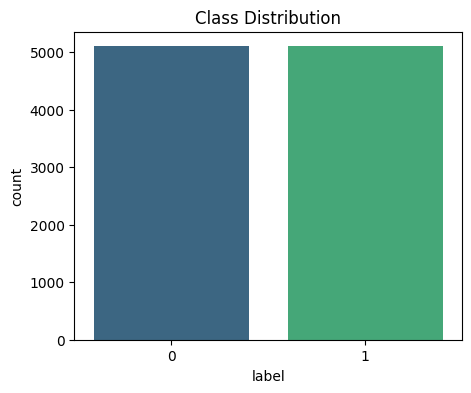

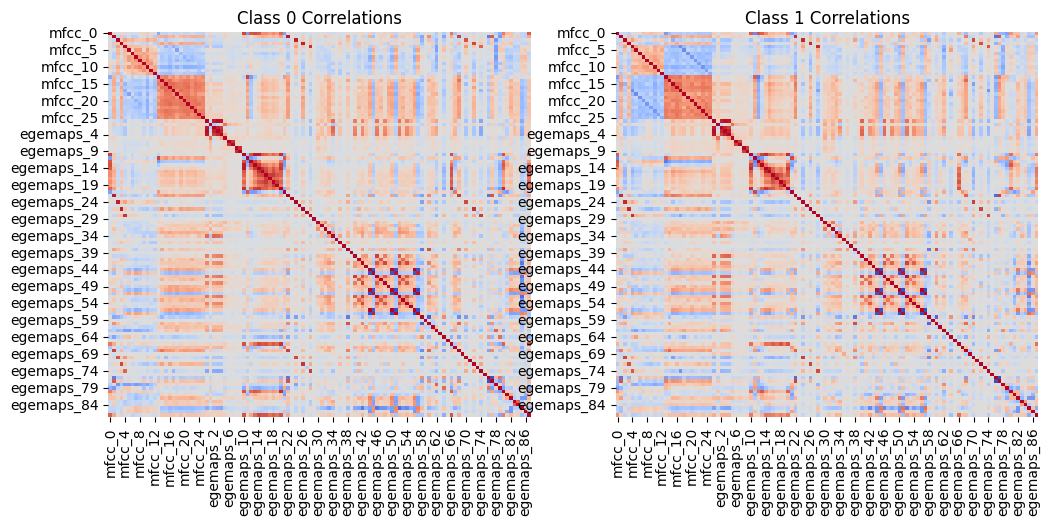

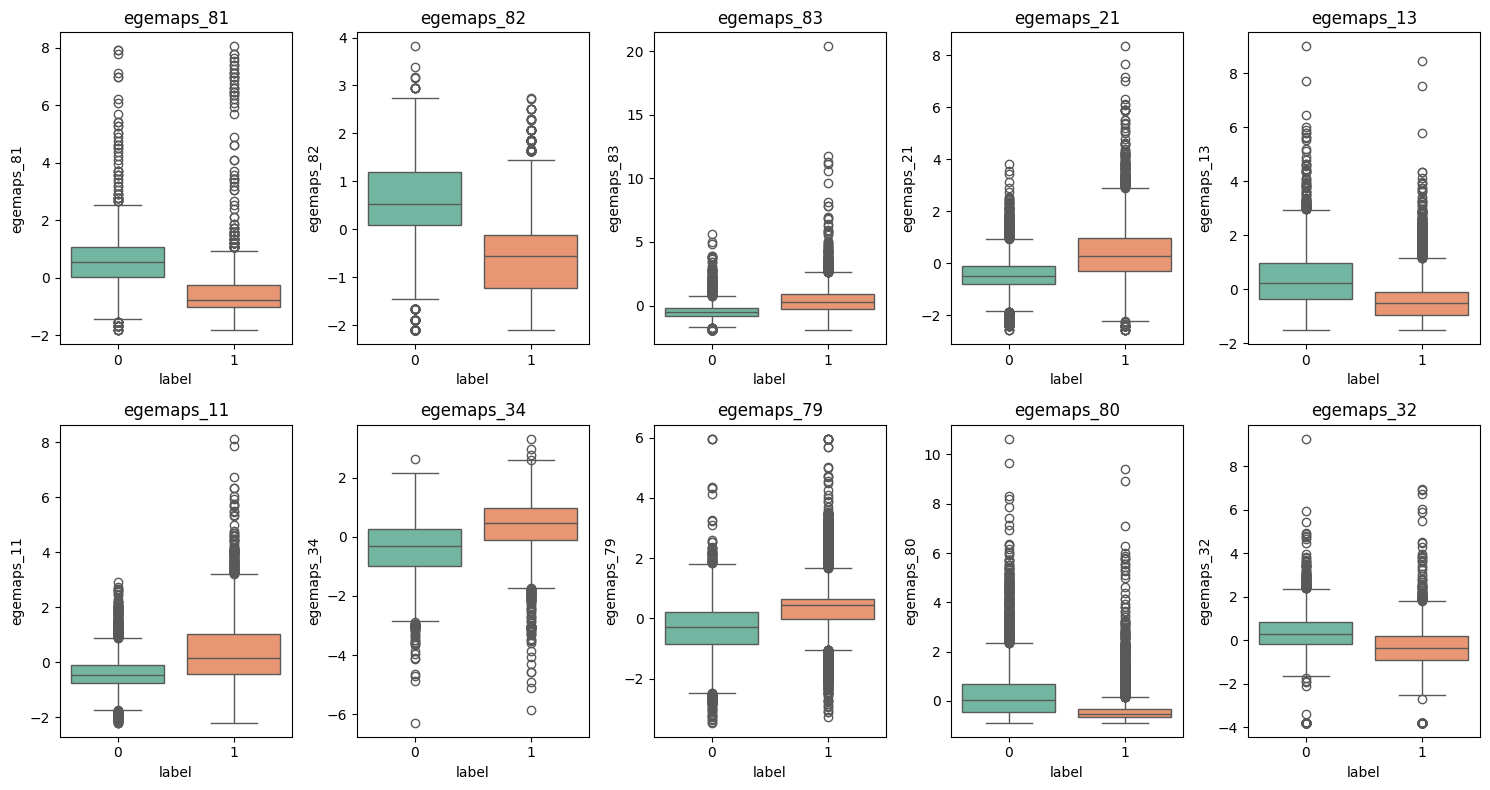

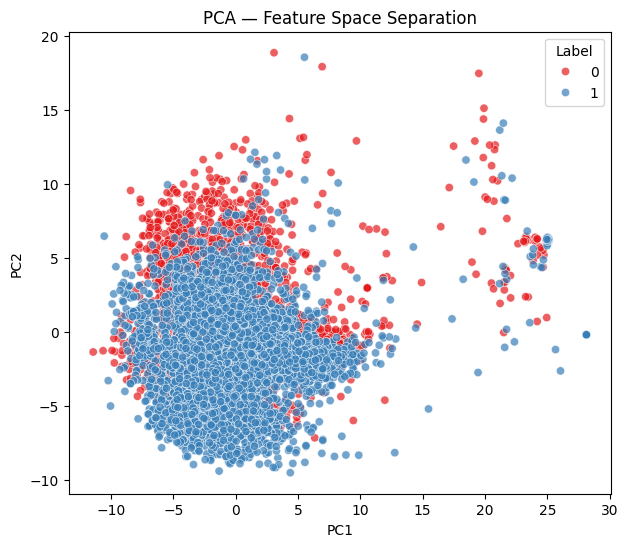


===== Running t-SNE Visualizations =====


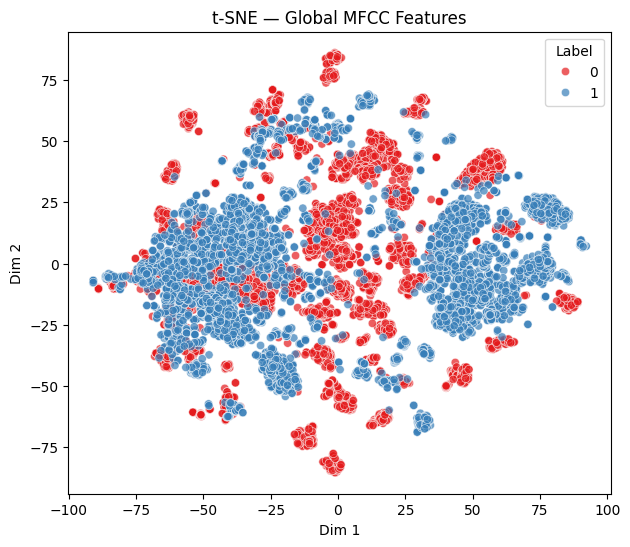

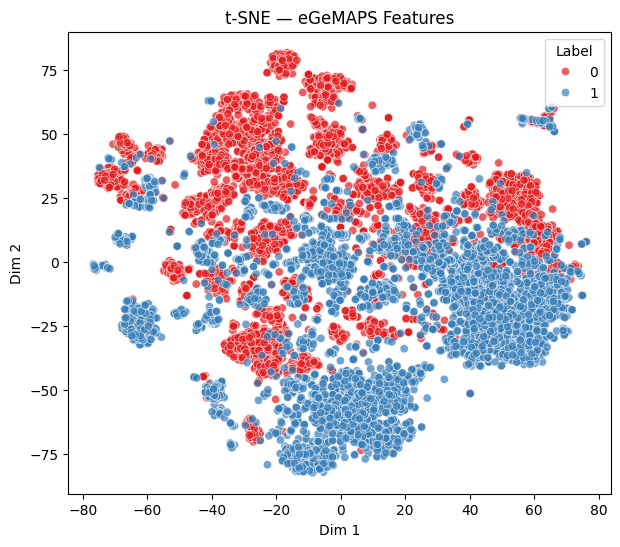

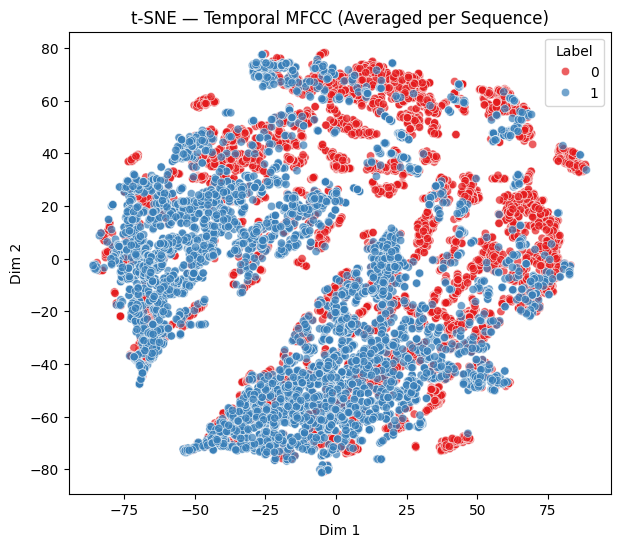

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# ====== Load CSV ======
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/saved_models/audio_features_debug.csv")

# ====== Basic Info ======
print("Shape:", df.shape)
print("Columns:", df.columns)
print(df['label'].value_counts())

# ====== Separate classes ======
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]

# ====== Compute Mean Differences ======
feature_cols = [c for c in df.columns if c != 'label']
mean_diff = (class_1[feature_cols].mean() - class_0[feature_cols].mean()).abs()
top_features = mean_diff.sort_values(ascending=False).head(10).index.tolist()

print("\nTop 10 discriminative features:")
print(top_features)

# ====== Plot class distribution ======
plt.figure(figsize=(5, 4))
sns.countplot(x='label', data=df, palette='viridis')
plt.title("Class Distribution")
plt.show()

# ====== Correlation Heatmaps per Class ======
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(class_0[feature_cols].corr(), ax=axes[0], cmap="coolwarm", cbar=False)
axes[0].set_title("Class 0 Correlations")

sns.heatmap(class_1[feature_cols].corr(), ax=axes[1], cmap="coolwarm", cbar=False)
axes[1].set_title("Class 1 Correlations")

plt.show()

# ====== Boxplots for Top Features ======
plt.figure(figsize=(15, 8))
for i, feature in enumerate(top_features):
    plt.subplot(2, 5, i + 1)
    sns.boxplot(x='label', y=feature, data=df, palette='Set2')
    plt.title(feature)

plt.tight_layout()
plt.show()

# ====== PCA Visualization ======
X = df[feature_cols].fillna(0)
y = df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

plt.figure(figsize=(7, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=y, palette='Set1', alpha=0.7)
plt.title("PCA — Feature Space Separation")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Label")
plt.show()


# ============================================================
# ===============   T-SNE VISUALIZATIONS   ====================
# ============================================================

from sklearn.manifold import TSNE
import pickle

print("\n===== Running t-SNE Visualizations =====")

# ----------------------------------------
# 1) t-SNE for MFCC Global
# ----------------------------------------
mfcc_global_cols = [c for c in df.columns if c.startswith("mfcc_")]
X_mfcc_global = df[mfcc_global_cols].values

tsne_mfcc_global = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
mfcc_global_tsne = tsne_mfcc_global.fit_transform(X_mfcc_global)

plt.figure(figsize=(7, 6))
sns.scatterplot(x=mfcc_global_tsne[:, 0], y=mfcc_global_tsne[:, 1],
                hue=df['label'], palette='Set1', alpha=0.7)
plt.title("t-SNE — Global MFCC Features")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(title="Label")
plt.show()


# ----------------------------------------
# 2) t-SNE for eGeMAPS
# ----------------------------------------
egemaps_cols = [c for c in df.columns if c.startswith("egemaps_")]
X_egemaps = df[egemaps_cols].values

tsne_egemaps = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
egemaps_tsne = tsne_egemaps.fit_transform(X_egemaps)

plt.figure(figsize=(7, 6))
sns.scatterplot(x=egemaps_tsne[:, 0], y=egemaps_tsne[:, 1],
                hue=df['label'], palette='Set1', alpha=0.7)
plt.title("t-SNE — eGeMAPS Features")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(title="Label")
plt.show()


# ----------------------------------------
# 3) t-SNE for Temporal MFCC (averaged per sequence)
# ----------------------------------------
mfcc_temporal_path = "/content/drive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/saved_models/mfcc_temporal.pkl"

with open(mfcc_temporal_path, "rb") as f:
    mfcc_temporal, labels_temp = pickle.load(f)

# Reduce each MFCC sequence [13 × T] → 13D vector (mean across time)
mfcc_temporal_avg = np.array([np.mean(mfcc, axis=1) for mfcc in mfcc_temporal])

tsne_mfcc_temp = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
mfcc_temp_tsne = tsne_mfcc_temp.fit_transform(mfcc_temporal_avg)

plt.figure(figsize=(7, 6))
sns.scatterplot(x=mfcc_temp_tsne[:, 0], y=mfcc_temp_tsne[:, 1],
                hue=labels_temp, palette='Set1', alpha=0.7)
plt.title("t-SNE — Temporal MFCC (Averaged per Sequence)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(title="Label")
plt.show()

# MFCC+CNN  GeMAPs+MLP  Fusion of Both and Training

🚀 Starting Complete Speech Classification Pipeline...
PyTorch version: 2.9.0+cu126
CUDA available: False

Starting training...
Epoch 01 | LR=1.00000e-05 | Train loss=0.6831, acc=0.5939 | Val loss=0.5738, acc=0.7539
💾 Saved best model.
Epoch 02 | LR=1.00000e-05 | Train loss=0.5498, acc=0.7390 | Val loss=0.4912, acc=0.8098
💾 Saved best model.
Epoch 03 | LR=1.00000e-05 | Train loss=0.4828, acc=0.7862 | Val loss=0.4237, acc=0.8343
💾 Saved best model.
Epoch 04 | LR=1.00000e-05 | Train loss=0.4314, acc=0.8169 | Val loss=0.3854, acc=0.8500
💾 Saved best model.
Epoch 05 | LR=1.00000e-05 | Train loss=0.3899, acc=0.8348 | Val loss=0.3558, acc=0.8554
💾 Saved best model.
Epoch 06 | LR=1.00000e-05 | Train loss=0.3674, acc=0.8496 | Val loss=0.3272, acc=0.8676
💾 Saved best model.
Epoch 07 | LR=1.00000e-05 | Train loss=0.3561, acc=0.8511 | Val loss=0.3063, acc=0.8750
💾 Saved best model.
Epoch 08 | LR=1.00000e-05 | Train loss=0.3345, acc=0.8572 | Val loss=0.2902, acc=0.8784
💾 Saved best model.
Epoch 09 

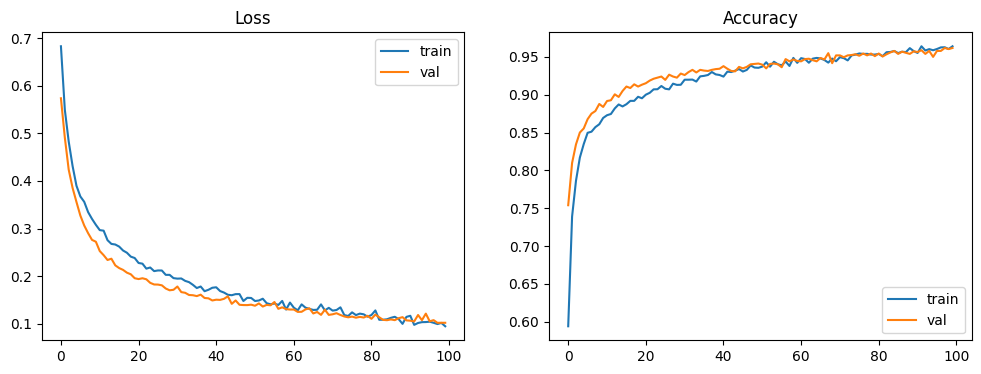


=== TEST NN Results ===
Accuracy: 0.9608035276825085
              precision    recall  f1-score   support

           0     0.9493    0.9735    0.9613      1020
           1     0.9729    0.9481    0.9603      1021

    accuracy                         0.9608      2041
   macro avg     0.9611    0.9608    0.9608      2041
weighted avg     0.9611    0.9608    0.9608      2041



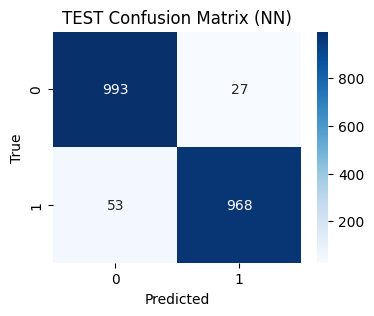


SUMMARY
NN best val acc (last recorded): 0.961764705882353
NN test acc: 0.9608035276825085
Saved results_summary.pkl
✅ Pipeline finished. Check saved plots and model files in: /content/drive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/saved_models


In [7]:
# ==========================================
# 🔧 IMPORTS
# ==========================================
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")

print("🚀 Starting Complete Speech Classification Pipeline...")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# ==========================================
# 1️⃣ LOAD FEATURES
# ==========================================
base_path = "/content/drive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/saved_models"
os.makedirs(base_path, exist_ok=True)

with open(os.path.join(base_path, "mfcc_temporal.pkl"), "rb") as f:
    mfcc, labels = pickle.load(f)

with open(os.path.join(base_path, "gemaps.pkl"), "rb") as f:
    gemaps_features, _ = pickle.load(f)

labels = np.array(labels)

# ==========================================
# 2️⃣ DATASET & COLLATE
# ==========================================
class AudioDataset(Dataset):
    def __init__(self, mfccs, gemaps, labels):
        self.mfccs = mfccs
        self.gemaps = gemaps
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        mfcc = np.asarray(self.mfccs[idx], dtype=np.float32)
        if mfcc.ndim == 2:
            mfcc = mfcc.T
        else:
            mfcc = mfcc.reshape(mfcc.shape[0], -1).T
        gemaps = np.asarray(self.gemaps[idx], dtype=np.float32)
        label = int(self.labels[idx])
        return torch.from_numpy(mfcc), torch.from_numpy(gemaps), torch.tensor(label, dtype=torch.long)

def collate_fn(batch):
    mfccs, gemaps, labels = zip(*batch)
    max_len = max([m.shape[0] for m in mfccs])
    max_feat = max([m.shape[1] for m in mfccs])
    padded = [torch.nn.functional.pad(m, (0, max_feat - m.shape[1], 0, max_len - m.shape[0])) for m in mfccs]
    return torch.stack(padded), torch.stack(gemaps), torch.stack(labels)

# ==========================================
# 3️⃣ DATA SPLIT + DATALOADER
# ==========================================
X_train, X_temp, y_train, y_temp, g_train, g_temp = train_test_split(
    mfcc, labels, gemaps_features, test_size=0.4, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test, g_val, g_test = train_test_split(
    X_temp, y_temp, g_temp, test_size=0.5, stratify=y_temp, random_state=42)

train_ds = AudioDataset(X_train, g_train, y_train)
val_ds = AudioDataset(X_val, g_val, y_val)
test_ds = AudioDataset(X_test, g_test, y_test)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# ==========================================
# 4️⃣ MODELS
# ==========================================
class MFCC_CNN(nn.Module):
    def __init__(self, embedding_dim=64, dropout_p=0.2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(16, 32, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d((2,2)),
            nn.Dropout(dropout_p),
            nn.Conv2d(32, 64, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Sequential(
            nn.Linear(64, embedding_dim),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_p)
        )

    def forward(self, x):
        x = x.permute(0,2,1).unsqueeze(1)
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        return self.fc(out)

class GeMAPs_MLP(nn.Module):
    def __init__(self, input_dim=88, embedding_dim=64, dropout_p=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_p),
            nn.Linear(128, embedding_dim),
            nn.LeakyReLU(0.1)
        )

    def forward(self, x):
        return self.net(x)

class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.scale = embed_dim ** 0.5

    def forward(self, x):
        # x: [B, D] -> reshape to [B, 1, D] for attention
        x = x.unsqueeze(1)
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        weights = torch.nn.functional.softmax(scores, dim=-1)
        attended = torch.matmul(weights, V)
        return attended.squeeze(1)

class FusionModel(nn.Module):
    def __init__(self, mfcc_emb_dim=64, gemaps_emb_dim=64, gemaps_input_dim=88, num_classes=2, dropout_p=0.3):
        super().__init__()
        self.mfcc_encoder = MFCC_CNN(embedding_dim=mfcc_emb_dim, dropout_p=dropout_p)
        self.gemaps_encoder = GeMAPs_MLP(input_dim=gemaps_input_dim, embedding_dim=gemaps_emb_dim, dropout_p=dropout_p)
        fused_dim = mfcc_emb_dim + gemaps_emb_dim
        self.attention = SelfAttention(fused_dim)
        self.classifier = nn.Sequential(
            nn.Linear(fused_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_p),
            nn.Linear(128, num_classes)
        )

    def forward(self, x_mfcc, x_gemaps):
        mfcc_emb = self.mfcc_encoder(x_mfcc)
        gemaps_emb = self.gemaps_encoder(x_gemaps)
        fused = torch.cat([mfcc_emb, gemaps_emb], dim=1)
        fused = fused+self.attention(fused)
        return self.classifier(fused), fused

# ==========================================
# 5️⃣ TRAINING SETUP
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FusionModel().to(device)
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=4, factor=0.7)

# ==========================================
# 6️⃣ TRAINING LOOP
# ==========================================
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x_mfcc, x_gemaps, y in loader:
        x_mfcc, x_gemaps, y = x_mfcc.to(device), x_gemaps.to(device), y.to(device)
        optimizer.zero_grad()
        logits, _ = model(x_mfcc, x_gemaps)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return total_loss / len(loader), correct / total

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x_mfcc, x_gemaps, y in loader:
            x_mfcc, x_gemaps, y = x_mfcc.to(device), x_gemaps.to(device), y.to(device)
            logits, _ = model(x_mfcc, x_gemaps)
            loss = criterion(logits, y)
            total_loss += loss.item()
            correct += (logits.argmax(1) == y).sum().item()
            total += y.size(0)
    return total_loss / len(loader), correct / total

# ==========================================
# 7️⃣ TRAINING LOOP
# ==========================================
num_epochs = 100
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_loss = float('inf')
early_stop = 0
patience = 10
save_path = os.path.join(base_path, "best_fusion_model.pth")
full_model_path = os.path.join(base_path, "best_fusion_model_full.pth")

print("\nStarting training...")
for epoch in range(1, num_epochs+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

    train_losses.append(tr_loss); val_losses.append(val_loss)
    train_accs.append(tr_acc); val_accs.append(val_acc)

    scheduler.step(val_loss)
    lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch:02d} | LR={lr:.5e} | Train loss={tr_loss:.4f}, acc={tr_acc:.4f} | Val loss={val_loss:.4f}, acc={val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        torch.save(model, full_model_path)
        print("💾 Saved best model.")
        early_stop = 0
    else:
        early_stop += 1
        if early_stop >= patience:
            print("🛑 Early stopping")
            break

# Save training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(train_losses, label="train"); plt.plot(val_losses, label="val"); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(train_accs, label="train"); plt.plot(val_accs, label="val"); plt.title("Accuracy"); plt.legend()
plt.savefig(os.path.join(base_path, "nn_training_curves.png"), dpi=200, bbox_inches='tight')
plt.show()

# ==========================================
# 8️⃣ NN EVALUATION
# ==========================================
def evaluate_nn(model, loader, device, splitname="TEST"):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_mfcc, x_gemaps, y in loader:
            x_mfcc = x_mfcc.to(device)
            x_gemaps = x_gemaps.to(device)
            y = y.to(device)

            logits, _ = model(x_mfcc, x_gemaps)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"\n=== {splitname} NN Results ===")
    print("Accuracy:", acc)
    print(classification_report(all_labels, all_preds, digits=4))
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{splitname} Confusion Matrix (NN)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(os.path.join(base_path, f"nn_cm_{splitname.lower()}.png"), dpi=200, bbox_inches='tight')
    plt.show()
    return acc

# Reload best model and evaluate
model.load_state_dict(torch.load(save_path, map_location=device))
test_acc_nn = evaluate_nn(model, test_loader, device, splitname="TEST")

# ==========================================
# 📋 SUMMARY & SAVE
# ==========================================
print("\nSUMMARY")
print("NN best val acc (last recorded):", max(val_accs) if val_accs else None)
print("NN test acc:", test_acc_nn)

results = {
    "nn_val_accs": val_accs,
    "nn_train_accs": train_accs,
    "nn_test_acc": test_acc_nn
}
with open(os.path.join(base_path, "results_summary.pkl"), "wb") as f:
    pickle.dump(results, f)
print("Saved results_summary.pkl")

print("✅ Pipeline finished. Check saved plots and model files in:", base_path)

# Down Syndrome Audio Severity Labeling and Random Forest Model

In [ ]:
# @title
# ============================================================
# 🎵 DOWN SYNDROME AUDIO SEVERITY LABELING + RANDOM FOREST MODEL
# ============================================================
# Colab-ready script:
# 1) Computes mean MFCC of normal audios
# 2) Labels Down Syndrome audios by MFCC deviation (Mild/Moderate/Severe)
# 3) Extracts temporal MFCC features (mean + std)
# 4) Trains Random Forest model (60/15/25 split)
# 5) Evaluates and saves model + plots confusion matrices
# ============================================================

import os
import librosa
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# ---------------------------
# 🔧 PATH CONFIGURATION
# ---------------------------
normal_folder = "/content/drive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/Augmented_Audio_Files/normal_people"
ds_folder     = "/content/drive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/Augmented_Audio_Files/down_syndrome_people"
output_base   = "/content/drive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/audio_files_with_severity"
base_path = "/content/drive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/saved_models"

os.makedirs(output_base, exist_ok=True)
for level in ['mild', 'moderate', 'severe']:
    os.makedirs(os.path.join(output_base, level), exist_ok=True)

# ---------------------------
# 🎼 FUNCTION: Extract Temporal MFCC (mean + std)
# ---------------------------
def extract_mfcc_temporal(audio_path, n_mfcc=13):
    """Extracts both mean and std of MFCCs for an audio file."""
    try:
        y, sr = librosa.load(audio_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # shape (n_mfcc, T)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std  = np.std(mfcc, axis=1)
        return np.concatenate([mfcc_mean, mfcc_std])  # shape (26,)
    except Exception as e:
        print(f"⚠️ Error processing {audio_path}: {e}")
        return None

# ---------------------------
# STEP 1️⃣ Compute Mean MFCC for Normal Audios
# ---------------------------
print("🎧 Calculating temporal MFCC mean for normal audios...")
normal_files = [os.path.join(normal_folder, f) for f in os.listdir(normal_folder) if f.endswith('.wav')]
normal_features = []

for f in tqdm(normal_files):
    feat = extract_mfcc_temporal(f)
    if feat is not None:
        normal_features.append(feat[:13])  # only MFCC mean part

if len(normal_features) == 0:
    raise RuntimeError("No normal features found. Check normal_folder path and files.")

mean_mfcc_normal = np.mean(np.stack(normal_features), axis=0)  # shape (13,)
np.save(os.path.join(output_base, "mean_mfcc_normal.npy"), mean_mfcc_normal)
print("✅ Normal mean MFCC saved.\n")

# ---------------------------
# STEP 2️⃣ Label Down Syndrome Audios by Deviation
# ---------------------------
print("🎤 Labeling Down Syndrome audios...")
ds_files = sorted([f for f in os.listdir(ds_folder) if f.endswith('.wav')])
results = []

for idx, f in enumerate(tqdm(ds_files, desc="Processing DS audios")):
    path = os.path.join(ds_folder, f)
    mfcc_vec = extract_mfcc_temporal(path)
    if mfcc_vec is None:
        continue

    # deviation using mean part (first 13 entries)
    denom = np.linalg.norm(mean_mfcc_normal)
    if denom == 0:
        raise ValueError("mean_mfcc_normal has zero norm.")
    deviation = np.linalg.norm(mfcc_vec[:13] - mean_mfcc_normal) / denom * 100.0

    if deviation < 40:
        severity = "mild"
    elif deviation < 70:
        severity = "moderate"
    else:
        severity = "severe"

    new_name = f"DS{idx+1:03d}.wav"
    dest_path = os.path.join(output_base, severity, new_name)
    shutil.copy2(path, dest_path)

    results.append({
        "Original_File": f,
        "New_Name": new_name,
        "Deviation(%)": round(deviation, 2),
        "Severity": severity.capitalize(),
        "Original_Path": path
    })

# Save CSV of assigned labels
df = pd.DataFrame(results)
csv_out = os.path.join(base_path, "severity_labels.csv")
df.to_csv(csv_out, index=False)
print(f"\n✅ All Down Syndrome audios labeled and saved! CSV -> {csv_out}\n")

severity_counts = pd.DataFrame(results)["Severity"].value_counts()
print("\n📊 Severity Label Counts:")
for severity, count in severity_counts.items():
    print(f" - {severity}: {count} audio files")


# ---------------------------
# STEP 3️⃣ Prepare Dataset for Training (temporal features)
# ---------------------------
print("📦 Preparing dataset for training...")
X, y = [], []
for label in ['mild', 'moderate', 'severe']:
    folder = os.path.join(output_base, label)
    if not os.path.exists(folder):
        continue
    files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.wav')]
    for fpath in files:
        feat = extract_mfcc_temporal(fpath)
        if feat is not None:
            X.append(feat)
            y.append(label.capitalize())

X = np.array(X)  # shape (N, 26)
y = np.array(y)

if len(X) == 0:
    raise RuntimeError("No labeled DS files found in output folders. Did labeling run correctly?")

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # classes in le.classes_

# ---------------------------
# STEP 4️⃣ Train/Val/Test Split (60/15/25)
# ---------------------------
# Split: Train 60% + Temp 40%
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.4, stratify=y_encoded, random_state=42
)

# From temp (40%) create Val (15%) and Test (25%):
# val should be 15% of total -> val_ratio = 15 / 40 = 0.375 of temp? Actually:
# We want validation = 15% total, test = 25% total -> relative split of temp: val = 15/40 = 0.375, test = 25/40 = 0.625
val_ratio = 15 / 40.0
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(25/40.0), stratify=y_temp, random_state=42
)

print(f"📊 Data sizes -> Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# ---------------------------
# STEP 5️⃣ Scale Features
# ---------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# ---------------------------
# STEP 6️⃣ Train Random Forest Classifier
# ---------------------------
print("\n🌲 Training Random Forest model...")
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train_scaled, y_train)

# ---------------------------
# STEP 7️⃣ Evaluation helper and plots
# ---------------------------
def evaluate(model, Xs, ys, name="Test"):
    preds = model.predict(Xs)
    print(f"\n📈 {name} Classification Report:\n")
    print(classification_report(ys, preds, target_names=le.classes_))

    cm = confusion_matrix(ys, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# evaluate on Train, Val, Test
evaluate(rf, X_train_scaled, y_train, "Train")
evaluate(rf, X_val_scaled, y_val, "Validation")
evaluate(rf, X_test_scaled, y_test, "Test")

importances = rf.feature_importances_
plt.bar(range(len(importances)), importances)
plt.title("Feature Importance (MFCC mean + std)")
plt.show()


# ---------------------------
# STEP 8️⃣ Save Model, Scaler, Encoder, and CSV
# ---------------------------

joblib.dump(rf, os.path.join(base_path, "severity_rf_model.pkl"))
joblib.dump(scaler, os.path.join(base_path, "severity_scaler.pkl"))
joblib.dump(le, os.path.join(base_path, "severity_label_encoder.pkl"))

print("\n💾 Model, scaler, and label encoder saved successfully!")
print(f"📁 All saved in: {base_path}")


# New Audio Classification

In [11]:
# @title
import torch
import torch.nn.functional as sp
import numpy as np
import librosa
import opensmile
import pickle
import os

# === Paths ===
base_path = "/content/drive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/saved_models"
#path = "/content/drive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/audio_files_with_severity"
model_path = os.path.join(base_path, "best_fusion_model.pth")
scaler_mfcc_path = os.path.join(base_path, "scaler_mfcc.pkl")
scaler_gemaps_path = os.path.join(base_path, "scaler_gemaps.pkl")
#mean_mfcc_path = os.path.join(path, "mean_mfcc_normal.npy")
#mean_mfcc_normal = np.load(mean_mfcc_path)


# === Load model and scalers ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FusionModel().to(device)

# Load weights
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()


with open(scaler_gemaps_path, "rb") as f:
    scaler_gemaps = pickle.load(f)

# === Feature extraction functions ===
def extract_mfcc(audio_path, n_mfcc=13):
    y, sr = librosa.load(audio_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # shape: [n_mfcc, T]
    return mfcc

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals
)

def extract_gemaps(audio_path):
    features_df = smile.process_file(audio_path)
    return features_df.iloc[0].values.flatten()

# === Inference function ===
def classify_audio(audio_path):
    # Extract features
    mfcc_seq = extract_mfcc(audio_path)  # shape: [n_mfcc, T]
    gemaps_vec = extract_gemaps(audio_path)  # shape: [88]

    # Normalize GeMAPS
    gemaps_vec = scaler_gemaps.transform([gemaps_vec])[0]

    # Convert MFCC to [T, F]
    mfcc_seq = mfcc_seq.T.astype(np.float32)
    T, F = mfcc_seq.shape

    # Pad MFCC to match training max length
    max_len = 300
    if T < max_len:
        pad = np.zeros((max_len - T, F), dtype=np.float32)
        mfcc_seq = np.vstack([mfcc_seq, pad])
    elif T > max_len:
        mfcc_seq = mfcc_seq[:max_len, :]

    # Convert to tensors
    mfcc_tensor = torch.from_numpy(mfcc_seq).unsqueeze(0).to(device).float()
    gemaps_tensor = torch.from_numpy(gemaps_vec).unsqueeze(0).to(device).float()

    # Run binary classification model
    with torch.no_grad():
        logits, _ = model(mfcc_tensor, gemaps_tensor)
        probs = sp.softmax(logits, dim=1).cpu().numpy()[0]
        pred = np.argmax(probs)

    label_map = {0: "Normal Speech", 1: "Down Syndrome Speech"}
    print(f"🧠 Prediction: {label_map[pred]} (Confidence: {probs[pred]:.4f})")

    # If Down Syndrome, check severity
   # if pred == 1:
   #     mfcc_mean = np.mean(mfcc_seq, axis=0)  # shape: [13]
   #     denom = np.linalg.norm(mean_mfcc_normal)
   #     deviation = np.linalg.norm(mfcc_mean - mean_mfcc_normal) / denom * 100.0

   #     if deviation < 40:
   #         severity = "Mild"
   #     elif deviation < 70:
   #         severity = "Moderate"
   #     else:
   #         severity = "Severe"

    #print(f"🔍 Severity: {severity} (Deviation: {deviation:.2f}%)")

    #return pred, probs

# === Example usage ===
new_audio_path = "/content/drive/MyDrive/Colab Notebooks/Audio_Assessment/Dataset/new_audio/test_1.wav"
classify_audio(new_audio_path)

🧠 Prediction: Down Syndrome Speech (Confidence: 0.6435)
